In [7]:
import pandas as pd
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

In [2]:
with open("raw_tables_2023_03_05/raw_tweets", "rb") as raw_timeline_file:
    tweet_df = pd.read_pickle(raw_timeline_file)
    # tweet_df.to_csv('raw_tweets_out.csv')
    print(tweet_df["content"].head(5))

0    I applaud North Carolina’s announcement to exp...
1    I’m so proud to have the Young Men’s Leadershi...
2    Happy Women’s History Month! When women succee...
3                    Stay safe out there, North Texas!
4    Wishing my fellow Texans everywhere a happy Te...
Name: content, dtype: object


In [56]:
nltk.download('words')
import emoji
words = set(nltk.corpus.words.words())
stopwords = set(nltk.corpus.stopwords.words())

[nltk_data] Downloading package words to /Users/minfei/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [182]:
def clean_tweet(tweet):
    temp = re.sub("'", "", tweet) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp) #Remove @ sign
    temp = re.sub("#[A-Za-z0-9_]+","", temp) #Remove # sign
    temp = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", temp) #Remove http links
    temp = re.sub(r'\s*\b(?:https?:\/\/)?(?:www\.)?\S+\.(com|org|gov)\S*\b', ' ', temp)  # remove com/org/gov links
    temp = re.sub(r'\bbit\.ly\/\S*', '', temp)

    temp = " ".join(temp.split())
    temp = ''.join(c for c in temp if c not in emoji.EMOJI_DATA) #Remove Emojis
    
    temp = " ".join(w.lower() for w in nltk.wordpunct_tokenize(temp) if w.isalpha())
    # temp = [w for w in temp if w not in emoji.EMOJI_DATA if w not in stopwords ]

    # tweet = " ".join(tweet.split())
    # tweet = ''.join(c for c in tweet if c not in emoji.EMOJI_DATA) #Remove Emojis
    # tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
#     tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
#          if w.lower() in words or not w.isalpha()) #Remove non-english tweets (not 100% success)
    return temp


In [170]:
from nltk.stem import PorterStemmer
import emoji

ps = PorterStemmer()
import random
random.seed(123)
tweet_df_sample = tweet_df.sample(n = 1000)
tweet_df_sample.to_csv('tweet_df_sample.csv')

In [183]:
tweet_df_sample['tweet_cleaned'] = tweet_df_sample['content'].map(lambda x: clean_tweet(x))

In [184]:
tweet_df_sample.head(50)['content'].to_csv('temp1.csv')

In [185]:
tweet_df_sample.head(50)['tweet_cleaned'].to_csv('temp2.csv')

In [186]:
tweet_df_sample["content_words"] = tweet_df_sample["tweet_cleaned"].apply(word_tokenize)
tweet_df_sample["content_words"] = tweet_df_sample["content_words"].apply(lambda words: [emoji.replace_emoji(ps.stem(word.lower())) for word in words])
tweet_df_sample["content_words_length"] = tweet_df_sample["content_words"].apply(len)
print(tweet_df_sample["content_words"].head(5))

2953736                       [i, am, percent, against, the]
888574     [join, to, discuss, comey, memo, trump, north,...
1059280    [traffic, alert, a, rock, slide, ha, been, rep...
2941125    [sunris, at, reid, i, have, to, admit, that, i...
3227051    [sen, john, cornyn, visit, grapevin, crisi, ce...
Name: content_words, dtype: object


              word  count       idf
1864       lawless      1  6.908755
2064  mentalhealth      1  6.908755
2065       mention      1  6.908755
2066          menu      1  6.908755
2068        merkel      1  6.908755
2069       mermaid      1  6.908755
2070         merri      1  6.908755
2071          mess      1  6.908755
2063        mental      1  6.908755
2073        mexico      1  6.908755


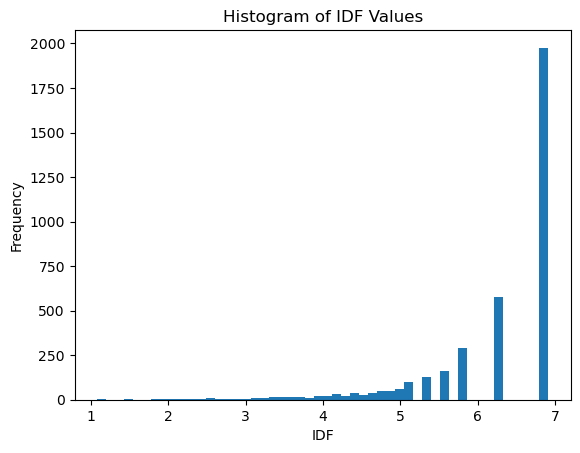

In [187]:
import numpy as np

id_list = []
word_list = []

for index, row in tweet_df_sample.iterrows():
    for word in set(row["content_words"]): 
        id_list.append(row["id"])
        word_list.append(word)


words_df = pd.DataFrame({"id": id_list, "word": word_list})
num_docs = tweet_df_sample.shape[0]

word_counts_df = words_df.groupby("word").count()
word_counts_df = word_counts_df.rename(columns={"id": "count"}).reset_index()
word_counts_df = word_counts_df.sort_values(by="count", ascending=True)

word_counts_df["idf"] = np.log(num_docs / word_counts_df["count"] + 1)

print(word_counts_df.head(10))

# Create a histogram of the IDF values
plt.hist(word_counts_df["idf"], bins=50)

# Set the plot title and axis labels
plt.title("Histogram of IDF Values")
plt.xlabel("IDF")
plt.ylabel("Frequency")

# Show the plot
plt.show()


In [188]:
word_counts_df.to_csv('word_counts_df.csv')
print(word_counts_df.shape)
print(num_docs)

(3729, 3)
1000


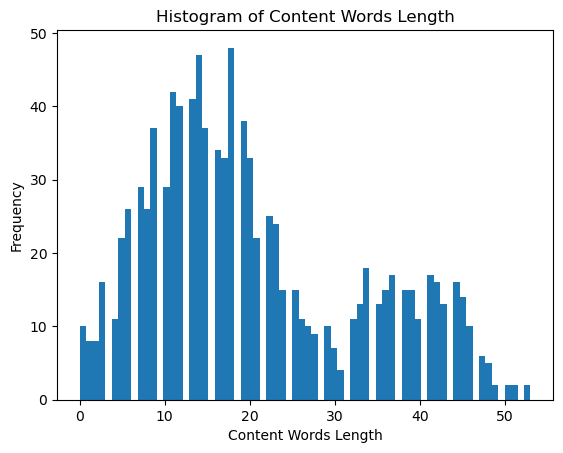

In [189]:
# Create a histogram of content_words_length
plt.hist(tweet_df_sample["content_words_length"], bins=70)

# Set the plot title and axis labels
plt.title("Histogram of Content Words Length")
plt.xlabel("Content Words Length")
plt.ylabel("Frequency")

# Show the plot
plt.show()

True     9113
False     887
Name: context_id, dtype: int64


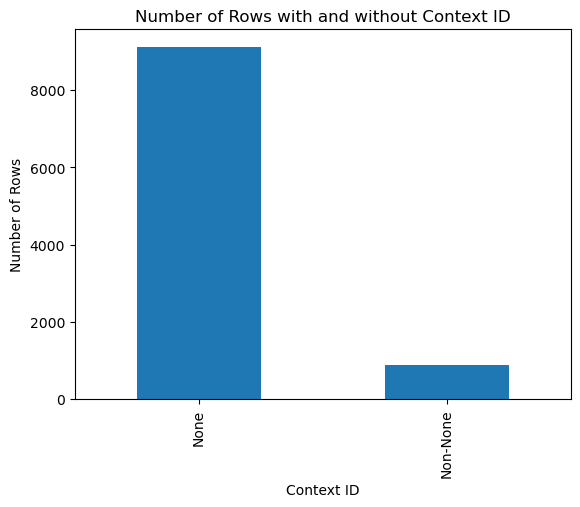

In [45]:
# Count the number of rows with and without a context_id value
context_counts = tweet_df_sample['context_id'].isna().value_counts()
print(context_counts)

# Create a bar chart of the context counts
context_counts.plot(kind='bar')

# Set the plot title and axis labels
plt.title('Number of Rows with and without Context ID')
plt.xlabel('Context ID')
plt.ylabel('Number of Rows')

# Set the x-axis tick labels
plt.xticks([0, 1], ['None', 'Non-None'])

# Show the plot
plt.show()